# Prototyping Model 0 - Raygun implemented in notebook form - for learning

In [2]:
import torch
import numpy as np
import os
import glob
from tqdm import tqdm 
import sys
import torch.nn as nn
import torch.nn.functional as F
import math
from esm.model.esm2 import TransformerLayer
from einops import rearrange, reduce
from einops import repeat, rearrange, reduce
from einops.layers.torch import Rearrange

# Dataloader: 
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import esm
from glob import glob
import h5py 
#from tqdm import tqdm
import re
from io import StringIO
import pandas as pd
import os
#import torch
#from einops import rearrange
from Bio import SeqIO

#Lightning_model_wrapper
import lightning as L
import torch
import numpy as np
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import logging
from Bio.Align import substitution_matrices
import numpy as np

#Train
import argparse
#from raygun.pretrained import raygun_4_4mil_800M
import yaml
#from torch.utils.data import DataLoader
#from tqdm import tqdm
#import torch.nn.functional as F
#import torch.nn as nn
#import numpy as np
#import torch
#import esm
#import os
#import pandas as pd
import itertools
import time
import json
#from Bio.Align import substitution_matrices
import subprocess
import logging 
#import lightning as L
import hydra
from omegaconf import DictConfig, OmegaConf
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb
from datetime import datetime
from pathlib import Path


#from raygun.modelv2.esmdecoder import DecoderBlock
#from raygun.modelv2.model_utils import Block, BlockP
#from raygun.modelv2.reduction import Reduction
#from raygun.modelv2.repetition import Repetition

# Hydra for managing config and parameter screens , would add a hubconf file for models

I am possibly going to move this after defining the model - we will see which is clearer

# Torch model (torch.nn)

The model will be made of an encoder and decoder. 

I will try and order the modules used in order they are being used - obviously they do not have to be used in that order - but this is just for my clarity. Some have multiple versions that I have written that you could choose between.

The architecture is an auto encoder model. This has an architecture where embeddings are generated and compressed (encoder) and decompressed and verified against the original (decoder). 

note for me - this is different to autoregressive decoder - for clarity for myself - autoencoder decoder. 

To see Ragun v2's architecture summary run:

```
from raygun.pretrained import raygun_2_2mil_800M
# 
raymodel = raygun_2_2mil_800M()
#raymodel = raymodel.to(0)
raymodel.eval()

```

Hyperparameters are here: https://github.com/rohitsinghlab/raygun/blob/main/hubconf.py - in the hubconf e.g. 



In [9]:
from raygun.pretrained import raygun_2_2mil_800M
# 
raymodel = raygun_2_2mil_800M()
#raymodel = raymodel.to(0)
raymodel.eval()

Using cache found in /hpc/home/khs36/.cache/torch/hub/rohitsinghlab_raygun_main


Downloading: "https://zenodo.org/records/15447158/files/model-may-16.ckpt?download=1" to /hpc/home/khs36/.cache/torch/hub/checkpoints/model-may-16.ckpt


100%|██████████| 3.10G/3.10G [02:23<00:00, 23.1MB/s]


Raygun(
  (encoder): RaygunEncoder(
    (encoders): ModuleList(
      (0-11): 12 x Block(
        (encoder): TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (rot_emb): RotaryEmbedding()
          )
          (self_attn_layer_norm): ESM1LayerNorm()
          (fc1): Linear(in_features=1280, out_features=2560, bias=True)
          (fc2): Linear(in_features=2560, out_features=1280, bias=True)
          (final_layer_norm): ESM1LayerNorm()
        )
        (convblock): ConvBlock(
          (c1): ConvMasked(
            (conv): Conv1d(1280, 640, kernel_size=(7,), stride=(1,), padding=valid)
          )
          (s1): SiLU()
          (c2): ConvMasked(
          

## Encoder parts:

### The first step is ESM2 - we take the final transformer layer embedding as input to the raygun step

ESM2 is itself an encoder only PLM, trained by meta. Its architecture summary is outputted in the cell below. It is trained using masking. i.e. residues are hidden and the model enters the correct ones. By doing this it must have some understanding (model) of both protein structure and function. From this as a base many further models have been generated. 


The first step - both tokenisation after which going through the layers generates the embedding. For our use, we take the final layer (see the data loader) output of ESM2 as the start for our encoder. Note that it uses rotary embeddings and multihead attention. Following this Raygun original currently does use the ESM2 architecture (not the model itself or weights - but the defined Transformer Layer architecture in the first step of Rayguns encoder - with 12 heads - I may change it - let's see

# Where this ESM step is in the Raygun code 

For the tokenising and generating embeddings step itself it is only seen in the DataLoader of the Raygun - and so in the loader.py in model version2 and then in the command in train - it outputs an embedding size 

```
## train and validation loaders
    traindata = RaygunData(fastafile = config["trainfasta"],
                           alphabet  = esmalphabet,
                           model     = esmmodel, 
                           device    = 0)
```

In the dataloader: self.bc        = self.alphabet.get_batch_converter()
this is esm.data.Alphabet class

This method is part of the ESM model loading utilities, and it's used to convert raw protein sequences into token IDs that the ESM transformer can understand.

# See S1 Aside - attention and multihead attention

See aside copied from the script where I was learning about that.


# See S2 Aside - rotary pos embeddings

See aside copied from the script where I was learning about that.


### Contact head bit

Note contact_head prediction uses the embedding generated (last layer) to predict contacts - pairs are turned into 1 or 0 - this indicates 3D structure - Note double check to see if this explanation is correct

From Gemini: 

regression: Linear(in_features=660, out_features=1, bias=True): A linear layer transforms the pair-wise feature into a single raw score.

activation: Sigmoid(): The sigmoid function squashes the score into a value between 0 and 1, which can be interpreted as the probability that the two protein residues are in contact.

### embed layer norm

. emb_layer_norm_after: LayerNorm

Role: This is a final Layer Normalization step applied to the entire output sequence of hidden states from the last of the 33 TransformerLayer modules.

Mechanism: It normalizes the activation of the final output embeddings (dimension 1280) across the features (the hidden dimension). This helps in stabilizing the distribution of the embeddings before they are consumed by the final prediction heads (contact_head and lm_head).

### lm_head: RobertaLMHead

Gemini:

Role: This head is responsible for the Language Modeling (LM) task, which, for ESM2, is primarily the Masked Amino Acid Prediction task it was trained on (similar to the original RoBERTa or BERT models). This allows the model to predict the identity of masked-out amino acids in a sequence.

Mechanism:

dense: Linear(in_features=1280, out_features=1280, bias=True): A feed-forward layer to further process the 1280-dimensional hidden states.

layer_norm: LayerNorm((1280,), eps=1e-05, elementwise_affine=True): Another normalization step applied to the processed hidden states.

Implicit Final Linear Layer: The provided snippet doesn't show the very last layer, but an LM Head typically has a final linear projection (often tied to the embedding weights) that maps the 1280-dimensional hidden state back to the size of the vocabulary (33 in this case: 20 standard amino acids + B, Z, X, U, O, J, start, end, padding, mask). The output is a set of logits over the vocabulary for each position in the sequence.



In [1]:
from esm.pretrained import esm2_t33_650M_UR50D

esm2model, alph = esm2_t33_650M_UR50D()

esm2model.eval()

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

# After the ESM2 embedding step - I can do multi-mixing etc. before the raygun reduction step

# After raygun full encoder (e.g. on the two parts separately - I can then do the mixing etc. and more layers before using the decoder architecture from raygun


# Step 1: Encoder - The first step of the two main step encoder is defined in the Block class
```
(0-11): 12 x Block(
        (encoder): TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (rot_emb): RotaryEmbedding()
          )
          (self_attn_layer_norm): ESM1LayerNorm()
          (fc1): Linear(in_features=1280, out_features=2560, bias=True)
          (fc2): Linear(in_features=2560, out_features=1280, bias=True)
          (final_layer_norm): ESM1LayerNorm()
        )
        (convblock): ConvBlock(
          (c1): ConvMasked(
            (conv): Conv1d(1280, 640, kernel_size=(7,), stride=(1,), padding=valid)
          )
          (s1): SiLU()
          (c2): ConvMasked(
            (conv): Conv1d(640, 320, kernel_size=(3,), stride=(1,), padding=valid)
          )
          (s2): SiLU()
          (c3): ConvMasked(
            (conv): Conv1d(320, 640, kernel_size=(7,), stride=(1,), padding=valid)
          )
          (s3): SiLU()
        )
        (final): Linear(in_features=640, out_features=1280, bias=True)
      )
    )
```

This is the first part of the class Raygun Encoder:
```
        self.encoders = nn.ModuleList()
        for i in range(numencoders):
            self.encoders.append(Block(dim = dim, 
                                       convkernel = convkernel, 
                                       attnheads = nhead))

```
This is implemented in Block which is stored in model_utils

This is composed of a normal layer from ESM2 , followed by a convolutional block

# The TransformerLayer function is from ESM2: It has this structure: 

```
class TransformerLayer(nn.Module):
    """Transformer layer block."""

    def __init__(
        self,
        embed_dim,
        ffn_embed_dim,
        attention_heads,
        add_bias_kv=True,
        use_esm1b_layer_norm=False,
        use_rotary_embeddings: bool = False,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.ffn_embed_dim = ffn_embed_dim
        self.attention_heads = attention_heads
        self.use_rotary_embeddings = use_rotary_embeddings
        self._init_submodules(add_bias_kv, use_esm1b_layer_norm)

    def _init_submodules(self, add_bias_kv, use_esm1b_layer_norm):
        BertLayerNorm = ESM1bLayerNorm if use_esm1b_layer_norm else ESM1LayerNorm

        self.self_attn = MultiheadAttention(
            self.embed_dim,
            self.attention_heads,
            add_bias_kv=add_bias_kv,
            add_zero_attn=False,
            use_rotary_embeddings=self.use_rotary_embeddings,
        )
        self.self_attn_layer_norm = BertLayerNorm(self.embed_dim)

        self.fc1 = nn.Linear(self.embed_dim, self.ffn_embed_dim)
        self.fc2 = nn.Linear(self.ffn_embed_dim, self.embed_dim)

        self.final_layer_norm = BertLayerNorm(self.embed_dim)

    def forward(
        self, x, self_attn_mask=None, self_attn_padding_mask=None, need_head_weights=False
    ):
        residual = x
        x = self.self_attn_layer_norm(x)
        x, attn = self.self_attn( 
            query=x,
            key=x,
            value=x,
            key_padding_mask=self_attn_padding_mask,
            need_weights=True,
            need_head_weights=need_head_weights,
            attn_mask=self_attn_mask,
        )
        x = residual + x
### note what the above is doing I think is pulling new embedding from ESM1LayerNorm for attention then adding that to the output of the previous layer to then output to the subsequent layer.

        residual = x
        x = self.final_layer_norm(x)
        x = gelu(self.fc1(x))
        x = self.fc2(x)
        x = residual + x

        return x, attn
```
It can be seen printed within the Block 

* Note here just using the ESM2 architecture rather than having to define our own

ESM output: (batch_size, sequence_length, embedding_dim) b n c
I think when in batch - pads to a fixed length - maybe of the shortest dim / fixed length not sure) - then masks. - 

In [3]:
class Block(nn.Module):
    def __init__(self, dim = 2560, attnheads = 5, convkernel = 7):
        super(Block, self).__init__()
        self.encoder = TransformerLayer(embed_dim = dim, 
                                       ffn_embed_dim = 2 * dim,
                                       attention_heads = attnheads,
                                       use_rotary_embeddings = True)
        
        self.convblock = ConvBlock(dim, convkernel)
        self.final = nn.Linear(dim // 2, dim)
        
    def forward(self, x, mask = None):
        x    = rearrange(x, "b n c -> n b c") #changes so now (sequence_length, batch_dim, embedding_dim)
        x, _ = self.encoder(x, self_attn_padding_mask = ~mask if mask is not None else mask) # likely mask.shape == (batch_size, seq_len)) - check mask is 0 or not
        x    = rearrange(x, "n b c -> b n c")

        x    = self.convblock(x, mask = mask)
        
        return self.final(x)

# the above calls the ConvBlock function - block is built on Convblock

# Convblock is itself built on ConvMasked
# Convolution is essentially a low pass filter - here it must help extract important features
# See aside below for notes

class ConvBlock(nn.Module):
    def __init__(self, dim, convkernel):
        super(ConvBlock, self).__init__()
        self.c1 = ConvMasked(dim     , dim // 2, kernel_size=convkernel)
        self.s1 = nn.SiLU()
        self.c2 = ConvMasked(dim // 2, dim // 4, kernel_size=convkernel // 2)
        self.s2 = nn.SiLU()
        self.c3 = ConvMasked(dim // 4, dim // 2, kernel_size=convkernel)
        self.s3 = nn.SiLU()
        return
    
    def forward(self, x, mask = None): 
        x = rearrange(x, "b n c -> b c n")
        if mask is not None:
            x = x * mask.unsqueeze(1)
        x = self.s1(self.c1(x, mask)) # uses SiLU activation functions, 
        x = self.s2(self.c2(x, mask))
        x = self.s3(self.c3(x, mask))
        x = rearrange(x, "b c n -> b n c") 
        return x

class ConvMasked(nn.Module):
    """
    Applied modifications on Conv1d to make the masking work
    """
    def __init__(self, indim, outdim, kernel_size):
        super(ConvMasked, self).__init__()
        self.conv        = nn.Conv1d(indim, outdim, 
                                    kernel_size = kernel_size, padding = "valid") #same as padding=0
        self.kernel_size = kernel_size
        self.indim       = indim

    def forward(self, x, mask = None):
        batch, _, _ = x.shape
        padding = torch.zeros(batch, self.indim, self.kernel_size - 1).to(x.device)
        x1      = torch.concat([x, padding], dim = 2) 
        # This is right padding - when using autoregression you want left padding/ causal time etc., 
        #not sure why right padding? - I think it is possibly to keep masking along the padding note I think b c n is the format
        # or could be to correct for the uneven weighting of start vs enf "pad" if doesn't divide by 50 
        # For mine -think about convolution state
        y       =  self.conv(x1)
        if mask is not None:
            y   = y * mask.unsqueeze(1) # unsqueeze the seequence part
        return y
        #to reduce edge bias - might be better to do padding='same' rather than the custom padding bit
        # note that default stride = 1
        # Get someone to explain the reason raygun does this

        # note ask about choice of input and output channels.

#the weights in the Conv1d layers (ConvMasked) are initialized using PyTorch’s defaults, which follow the Kaiming Uniform (He Uniform) initialization scheme.



In [4]:
block = Block()
print(block)

# If you look at the convolutions you seem to be ssquishing twice and then expanding once,
# and then once more expanding in the final linear 

Block(
  (encoder): TransformerLayer(
    (self_attn): MultiheadAttention(
      (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
      (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
      (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
      (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
      (rot_emb): RotaryEmbedding()
    )
    (self_attn_layer_norm): ESM1LayerNorm()
    (fc1): Linear(in_features=2560, out_features=5120, bias=True)
    (fc2): Linear(in_features=5120, out_features=2560, bias=True)
    (final_layer_norm): ESM1LayerNorm()
  )
  (convblock): ConvBlock(
    (c1): ConvMasked(
      (conv): Conv1d(2560, 1280, kernel_size=(7,), stride=(1,), padding=valid)
    )
    (s1): SiLU()
    (c2): ConvMasked(
      (conv): Conv1d(1280, 640, kernel_size=(3,), stride=(1,), padding=valid)
    )
    (s2): SiLU()
    (c3): ConvMasked(
      (conv): Conv1d(640, 1280, kernel_size=(7,), stride=(1,), padding=valid)
    )

# Reduction and Final bits of the Encoder part

The final bits of the encoder function are to do the dimensionality reduction, 
- i.e. to fixed size representation followed by the last couple of layers.

    (reduction): Reduction()
    (final): Sequential(
      (0): Linear(in_features=16640, out_features=392, bias=True)
      (1): SiLU()
      (2): Linear(in_features=392, out_features=1280, bias=True)
    )
  )

This is in here:
```
class RaygunEncoder(nn.Module):
    def __init__(self, dim = 1280, reduction = 50,
                 convkernel = 7,
                 nhead = 20, numencoders = 2, dropout = 0.2,
                 activation = "gelu"):
        super(RaygunEncoder, self).__init__()
        self.dropout = dropout

        self.encoders = nn.ModuleList()
        for i in range(numencoders):
            self.encoders.append(Block(dim = dim, 
                                       convkernel = convkernel, 
                                       attnheads = nhead))


        self.redlength = reduction
        self.reduction = Reduction(reduce_size = reduction)

-------------------------------------------------------------------------

        self.final     = nn.Sequential(
                            nn.Linear(dim * (numencoders+1), dim // (numencoders + 1) * 4),
                            nn.SiLU(),
                            nn.Linear(dim // (numencoders + 1) * 4, dim)
                         )

        nn.init.xavier_uniform_(self.final[0].weight, gain=1e-3)
        nn.init.xavier_uniform_(self.final[2].weight, gain=1e-3)
        nn.init.constant_(self.final[0].bias, 0)
        nn.init.constant_(self.final[2].bias, 0)
```

You append the block outputs to a Module list (in this version of the model there are the initial embedding pluss 12 of them. If you look at the ESM encoder class you do that on the batch  - an then finally combine them in the self.final bit.

The reduction process itself is self explanatory if you look at the function - I thought up a few possible alternatives - but they're not necessarily formatted to fit in.

The inits - initialise the weights to very small values to start off with. (Apparently once there are existing weights stored - this code will be ignored. 

The reason this is here is to overwrite the default initialisations

In [6]:
#Raygun original reduction - this is in the encoder part
class Reduction(nn.Module):
    def __init__(self, reduce_size = 50, dim = 1280):
        self.reduce_size = reduce_size
        super(Reduction, self).__init__()
        return
    
    def forward(self, x, mask = None, getstd = False):
        """
        return the sigma of noise from x, in addition to the reduction
        """
        batch, _, dim = x.shape

        if mask == None:
            ## batch, seqlen
            mask = torch.ones_like(x[:, :, 0], dtype = int)
        
        seqs     = torch.sum(mask, dim = 1) 
        xmeans   = []
        xstds    = []
        for i in range(batch):
            min_window_size  = seqs[i] // self.reduce_size
            gap              = seqs[i] - min_window_size * self.reduce_size
            gapleft          = gap // 2
            gapright         = gap // 2
            if gap % 2 == 1:
                gapleft += 1
            mid = self.reduce_size - gap
            
            firstbeg, firstend = 0, gapleft * (min_window_size + 1)
            lastbeg, lastend   = seqs[i] - gapright * (min_window_size + 1), seqs[i]
            midbeg, midend     = gapleft * (min_window_size + 1), gapleft * (min_window_size + 1) + mid * min_window_size
        
            xstart   = x[i, firstbeg:firstend, :].unsqueeze(0)
            xmid     = x[i, midbeg:midend, :].unsqueeze(0)
            xend     = x[i, lastbeg:lastend, :].unsqueeze(0)
            
            xstmean  = self.get_mean_std(xstart, min_window_size + 1, dim,
                                                getstd, returnzero = (gapleft == 0), 
                                                device = x.device)
            xmidmean = self.get_mean_std(xmid, min_window_size, dim,
                                                    getstd, returnzero = False,
                                                    device = x.device)
            xendmean = self.get_mean_std(xend, min_window_size + 1, dim,
                                                    getstd, returnzero = (gapright == 0),
                                                    device = x.device)
            if getstd:
                xstmean, xststd   = xstmean
                xmidmean, xmidstd = xmidmean
                xendmean, xendstd = xendmean
                xmean = torch.concat([xstmean, xmidmean, xendmean], dim = 1)
                xstd  = torch.concat([xststd, xmidstd, xendstd], dim = 1)
                xmeans.append(xmean)
                xstds.append(xstd)
            else:
                xmean = torch.concat([xstmean, xmidmean, xendmean], dim = 1)
                xmeans.append(xmean)
        if getstd:
            return torch.concat(xmeans, dim = 0), torch.concat(xstds, dim = 0)
        else:
            return torch.concat(xmeans, dim = 0)

    def get_mean_std(self, x, windowsize, dim,
                     getstd = False, returnzero = False, 
                     device = "cpu"):
        if returnzero:
            if getstd:
                return torch.zeros(1, 0, dim).to(device), torch.zeros(1, 0, dim).to(x.device)
            else:
                return torch.zeros(1, 0, dim).to(device)
        xredmean = reduce(x, "b (x dx) c -> b x c", "mean",
                          dx = windowsize)
        if getstd:
            xdiff = x - repeat(xredmean, "b x c -> b (x dx) c", 
                          dx = windowsize)
            xdiffsq = xdiff * xdiff
            xmidstd = torch.sqrt(reduce(xdiffsq, "b (x dx) c -> b x c", "mean", 
                                       dx = windowsize))
            return xredmean, xmidstd
        else:
            return xredmean

#Simpler reduction using einops expand and reduce to have evenly distributed which also makes easy standard deviation
#It also allows smaller than 50 elements to be expanded with the same function - expanding the scope
#Not sure if it will be wors or work ok - can see the benefit of keeping a whole number binning like the original
#This will be BAD for memory! - but writing it anyway.
#Check whether standard deviation is used at all in training - or if it's just an addition for the final so that noise can be added
#this noise is for generating diversity

class ReductionEven_einops(nn.Module):
    def __init__(self, reduce_size=50):
        super().__init__()
        self.reduce_size = reduce_size

    def forward(self, x, getstd=False):
        """
        x: [batch, seq_len, dim]
        Returns:
            xmean: [batch, reduce_size, dim]
            xstd:  [batch, reduce_size, dim] if getstd=True
        """
        batch, seq_len, dim = x.shape

        # Step 1: repeat each timestep 50x
        x_expanded = repeat(x, "b s d -> b (s r) d", r=50)  # [batch, seq_len*50, dim]

        # Step 2: reduce into reduce_size chunks
        dx = x_expanded.shape[1] // self.reduce_size  # window size for reduction
        xmean = reduce(x_expanded, "b (x dx) d -> b x d", "mean", dx=dx)

        if getstd:
            # expand mean back to repeated length to compute std
            x_diff = x_expanded - repeat(xmean, "b x d -> b (x dx) d", dx=dx)
            xstd = reduce(x_diff**2, "b (x dx) d -> b x d", "mean", dx=dx).sqrt()
            return xmean, xstd

        return xmean

# Simpler reduction using nn to have evenly distributed using 'F.adaptive_avg_pool1d'
#As before Not sure if it will be worse or work ok - can see the benefit of keeping a whole number binning like the original
class ReductionAdaptive(nn.Module):
    def __init__(self, reduce_size=50):
        super().__init__()
        self.reduce_size = reduce_size

    def forward(self, x, getstd=False):
        """
        x: [batch, seq_len, dim]
        Returns:
            xmean: [batch, reduce_size, dim]
            xstd:  [batch, reduce_size, dim] if getstd=True
        """
        batch, seq_len, dim = x.shape

        # Permute to [batch, dim, seq_len] for adaptive_avg_pool1d
        x_perm = x.permute(0, 2, 1)  # [B, D, L]

        # Step 1: Adaptive average pooling to fixed length
        x_mean = F.adaptive_avg_pool1d(x_perm, output_size=self.reduce_size)
        x_mean = x_mean.permute(0, 2, 1)  # [B, reduce_size, D]

        if getstd:
            # note while this uses more memory - it shouldn't be too bad as we are not actually training here 
            # in a memory limited setting - we can add a function that uses a for loop instead 
            #-this will fupport using the model on larger batches
            # Step 1: repeat each timestep 50x
            x_expanded = repeat(x, "b s d -> b (s r) d", r=50)  # [batch, seq_len*50, dim]
    
            # Step 2: reduce into reduce_size chunks
            dx = x_expanded.shape[1] // self.reduce_size  # window size for reduction
            mean = reduce(x_expanded, "b (x dx) d -> b x d", "mean", dx=dx)
    
            # expand mean back to repeated length to compute std
            diff = x_expanded - repeat(mean, "b x d -> b (x dx) d", dx=dx)
            xstd = reduce(diff**2, "b (x dx) d -> b x d", "mean", dx=dx).sqrt()
        
            return x_mean, xstd

        return x_mean
             

 #       if getstd:
        #this is going back to the 
            # Step 2: Compute standard deviation per pooled bin
            # 1. Compute weights of each input step for each pooled bin
            # 2. Expand x_mean back to original length using interpolation
            # Approximate by linear upsampling
 #           x_mean_expanded = F.interpolate(
 #               x_mean.permute(0, 2, 1), size=seq_len, mode='linear', align_corners=False
 #           ).permute(0, 2, 1)  # [B, seq_len, D]

            # 3. Compute per-bin squared deviations
 #           x_diff_sq = (x - x_mean_expanded) ** 2

            # 4. Reduce to same reduce_size bins
 #           x_diff_sq_perm = x_diff_sq.permute(0, 2, 1)  # [B, D, L]
 #           x_std = F.adaptive_avg_pool1d(x_diff_sq_perm, output_size=self.reduce_size).permute(0, 2, 1)
 #           x_std = torch.sqrt(x_std + 1e-8)  # epsilon for numerical stability
 #
 #           return x_mean, x_std

 #       return x_mean


# the original raygun Repetition - consider renaming it expansion for clarity - this is in the decoder part
class Repetition(nn.Module):
    def __init__(self):
        """
        self, noise_threshold
        """
        super(Repetition, self).__init__()
        return
        
    def forward(self, encoding, finallengths):
        """
        encoding     => torch.Tensor [batch, REDUCTION_DIM, 1280]; Fixed dimensional representations
        finallengths => torch.Tensor [batch]; target lengths for each batch
        """
        batch, encoderlength, dim = encoding.shape

        if isinstance(finallengths, int):
            assert batch == 1
            finallengths = torch.tensor([finallengths], dtype = int)

        xs = []
        maxlength = torch.max(finallengths)

        for i in range(batch):
            finallength = finallengths[i]
            reps        = finallength // encoderlength
            gap         = finallength % encoderlength
            gapleft     = gapright = gap // 2

            if gap % 2 == 1:
                gapleft += 1
            
            mid = encoderlength - gap
            if gapleft == 0:
                xstart = torch.zeros(1, 0, dim).to(encoding.device)
            else:
                encstart = encoding[i, :gapleft, :].unsqueeze(0)
                xstart = repeat(encstart, f"b h c -> b (h rep) c", rep=reps+1)
            encmid = encoding[i, gapleft:gapleft + mid, :].unsqueeze(0)
            xmid = repeat(encmid, f"b h c -> b (h rep) c", rep = reps)
            if gapright == 0:
                xend = torch.zeros(1, 0, dim).to(encoding.device)
            else:
                encend = encoding[i, gapleft + mid:, :].unsqueeze(0)
                xend = repeat(encend, f"b h c -> b (h rep) c", rep = reps+1)
            padding  = torch.zeros(1, maxlength - finallength, dim).to(encoding.device)
            xs.append(torch.concat([xstart, xmid, xend, padding], dim = 1))
        return torch.concat(xs, dim = 0)

#my repetition function - can also reduce the size below 50
#possibly very high use of memory (you are expanding by the output length
class ExpansionEven_einops(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, finallengths):
        """
        encoding     => torch.Tensor [batch, REDUCTION_DIM, 1280]; Fixed dimensional representations
        finallengths => torch.Tensor [batch]; target lengths for each batch
        """
        batch, seq_len, dim = encoding.shape
        
        for i in range(batch):
            finallength = finallengths[i]          

        # Step 1: repeat each timestep 50x
        x_expanded = repeat(x, "b s d -> b (s r) d", r=finallength)  # [batch, seq_len*50, dim]

        # Transpose so dim 1 becomes the last dimension
        x_expanded_t = x.transpose(1, 2)  # shape (2, 4, 5)

        # Interpolate along last dimension (originally dim 1)
        x_mean_t = F.interpolate(x_t, size=finallength, mode='linear', align_corners=False)
        
        # now I need to concatenate them together like in the example be for returning 
        #- but the shapes need to align - continue to write

        return  # add to return the final concatenated bit

# Can also do standard linear interpolation or nearest neighbour with smoothing - add below



class Reduction_and_Expansion_arearesamp_single(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, finallength):
        """
        x: Tensor of shape [B, L, D]
        finallength: int, new length for dimension 1 (L)
        Returns: [B, finallength, D]
        """
        B, L, D = x.shape  # [B, L, D]

        # Step 1: Transpose to [B, D, L] so L is the last dimension
        x = x.transpose(1, 2)  # [B, D, L]

        # Step 2: Add channel dim → [B, 1, D, L]
        x = x.unsqueeze(1)

        # Step 3: Interpolate with area mode
        x = F.interpolate(x, size=(D, finallength), mode='area')

        # Step 4: Remove channel dim → [B, D, finallength]
        x = x.squeeze(1)

        # Step 5: Transpose back to [B, finallength, D]
        x = x.transpose(1, 2)

        return x


class ReductionAndExpansionAreaResamp(nn.Module):
    """
    Resamples sequences with variable input and output lengths using 'area' interpolation.
    Supports masking of padded input tokens and variable target lengths per batch.

    Args:
        None (can later add stdev/noise parameters)

    Inputs:
        x: Tensor of shape [B, L_max, D]
        padding_mask: Bool tensor [B, L_max], where True = padded (invalid)
        finallength: int | list[int] | tensor[int]
            Target length(s) per batch element.

    Outputs:
        padded_out: Tensor [B, L_out_max, D] (zero-padded)
        out_mask:   Bool tensor [B, L_out_max] (True = padded)
    """

    def __init__(self):
        super().__init__()

    def forward(
        self,
        x: torch.Tensor,
        finallength,
        padding_mask: torch.Tensor = None,
    ):
        B, L_max, D = x.shape

        if padding_mask is None:
            padding_mask = torch.zeros(B, L_max, dtype=torch.bool, device=x.device)
        
        assert padding_mask.shape == (B, L_max), "padding_mask must be [B, L_max]"

        # Normalize finallength → Tensor[B]
        if isinstance(finallength, int):
            finallengths = torch.full((B,), finallength, dtype=torch.long, device=x.device)
        else:
            finallengths = torch.as_tensor(finallength, dtype=torch.long, device=x.device)
            assert finallengths.shape[0] == B, "finallength must have one value per batch element"

        # --- Preallocate outputs ---
        max_len_out = finallengths.max().item()
        padded_out = torch.zeros(B, max_len_out, D, dtype=x.dtype, device=x.device)
        out_mask = torch.ones(B, max_len_out, dtype=torch.bool, device=x.device)  # all padded initially

        # --- Single pass loop with enumerate ---
        for b, target_len in enumerate(finallengths.tolist()):
            # Extract valid (unpadded) region
            valid_len = (~padding_mask[b]).sum().item()
            seq = x[b, :valid_len]  # [L_b, D]

            # Interpolate to target length
            seq = seq.unsqueeze(0).transpose(1, 2).unsqueeze(1)  # [1, 1, D, L_b]
            out = F.interpolate(seq, size=(D, target_len), mode="area")
            out = out.squeeze(1).transpose(1, 2)  # [1, target_len, D]

            # Place in padded_out and mark valid positions in mask
            Lb = out.shape[1]
            padded_out[b, :Lb] = out
            out_mask[b, :Lb] = False  # False = valid, True = padded

        return padded_out, out_mask

        

        

        

        


    
    



In [40]:
# Note the below is not ready and does not fit into the model ....

class Reduction_and_Expansion_arearesamp(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, finallength): #recompute_scale_factor #align corners - I think this has no effect
        """
        x: Tensor of shape [B, L, D]
        finallength: int, new length for dimension 1 (L)
        Returns: [B, finallength, D]
        """
        B, L, D = x.shape  # [B, L, D]

        # Step 1: Transpose to [B, D, L] so L is the last dimension
        x = x.transpose(1, 2)  # [B, D, L]

        # Step 2: Add channel dim → [B, 1, D, L]
        x = x.unsqueeze(1)

        # Step 3: Interpolate with area mode
        x = F.interpolate(x, size=(D, finallength), mode='area')

        # Step 4: Remove channel dim → [B, D, finallength]
        x = x.squeeze(1)

        # Step 5: Transpose back to [B, finallength, D]
        x = x.transpose(1, 2)

        return x


# Create a 1D tensor [1, 2, 3, 4, 5]
vals = torch.arange(1, 11).view(1, 10, 1).float()  # Shape: [1, 5, 1]

# Expand to [1, 5, 3]
result = vals.expand(1, 10, 3)

print(result)
print(result.shape)  # torch.Size([1, 5, 3])

trial = Reduction_and_Expansion_arearesamp()

trial.forward(result,finallength=7)




tensor([[[ 1.,  1.,  1.],
         [ 2.,  2.,  2.],
         [ 3.,  3.,  3.],
         [ 4.,  4.,  4.],
         [ 5.,  5.,  5.],
         [ 6.,  6.,  6.],
         [ 7.,  7.,  7.],
         [ 8.,  8.,  8.],
         [ 9.,  9.,  9.],
         [10., 10., 10.]]])
torch.Size([1, 10, 3])


tensor([[[1.5000, 1.5000, 1.5000],
         [2.5000, 2.5000, 2.5000],
         [4.0000, 4.0000, 4.0000],
         [5.5000, 5.5000, 5.5000],
         [7.0000, 7.0000, 7.0000],
         [8.5000, 8.5000, 8.5000],
         [9.5000, 9.5000, 9.5000]]])

# The Full Encoder class that uses all the previous classes

In [7]:
#From raygun file (model vs2)
class RaygunEncoder(nn.Module):
    def __init__(self, dim = 1280, reduction = 50,
                 convkernel = 7,
                 nhead = 20, numencoders = 2, dropout = 0.2,
                 activation = "gelu"):
        super(RaygunEncoder, self).__init__()
        self.dropout = dropout

        self.encoders = nn.ModuleList()
        for i in range(numencoders):
            self.encoders.append(Block(dim = dim, 
                                       convkernel = convkernel, 
                                       attnheads = nhead))


        self.redlength = reduction
        self.reduction = Reduction(reduce_size = reduction)
        self.final     = nn.Sequential(
                            nn.Linear(dim * (numencoders+1), dim // (numencoders + 1) * 4),
                            nn.SiLU(),
                            nn.Linear(dim // (numencoders + 1) * 4, dim)
                         )

        nn.init.xavier_uniform_(self.final[0].weight, gain=1e-3)
        nn.init.xavier_uniform_(self.final[2].weight, gain=1e-3)
        nn.init.constant_(self.final[0].bias, 0)
        nn.init.constant_(self.final[2].bias, 0)

    def reduce(self, x, mask = None, noise = None):
        """
        Use the Reduction operation to compress the PLM representation to a fixed-dimension space.
        """
        batch, _, _ = x.shape
        if noise is not None:
            redmean, redstd = self.reduction(x, mask = mask, getstd = True)
            reduced = redmean + torch.randn_like(redstd, device = x.device) * redstd * noise
        else:
            reduced = self.reduction(x, mask = mask, getstd = False)
        return reduced

    def forward(self, x, mask = None, noise = None):
        """
        If error_c is provided, noise component is incorporated into the 
        fixed-dimensional representation. 
        """
        enc = self.reduce(x, mask = mask, noise = noise)
        residues = [enc]
        for mod in self.encoders:
            xresidue = mod(x, mask = mask)
            residue  = mod(self.reduce(xresidue, mask = mask, noise = noise)) # 
            x        = x + xresidue
            residues.append(residue)

        finalresidue = self.final(torch.concat(residues, dim = -1)) 
        return enc + finalresidue      

# Decoder Block

# Let's do the Same with the decoder block

(Less detail though as now we understand roughly what is going on

The decoder If you look at the model is very similar to the encoder but with repetition to expand back to a larger space
```
(decoder): RaygunDecoder(
    (dbefore): ModuleList(
      (0-11): 12 x Block(
        (encoder): TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (rot_emb): RotaryEmbedding()
          )
          (self_attn_layer_norm): ESM1LayerNorm()
          (fc1): Linear(in_features=1280, out_features=2560, bias=True)
          (fc2): Linear(in_features=2560, out_features=1280, bias=True)
          (final_layer_norm): ESM1LayerNorm()
        )
        (convblock): ConvBlock(
          (c1): ConvMasked(
            (conv): Conv1d(1280, 640, kernel_size=(7,), stride=(1,), padding=valid)
          )
          (s1): SiLU()
          (c2): ConvMasked(
            (conv): Conv1d(640, 320, kernel_size=(3,), stride=(1,), padding=valid)
          )
          (s2): SiLU()
          (c3): ConvMasked(
            (conv): Conv1d(320, 640, kernel_size=(7,), stride=(1,), padding=valid)
          )
          (s3): SiLU()
        )
        (final): Linear(in_features=640, out_features=1280, bias=True)
      )
    )
    (repetition): Repetition()
    (dafter): ModuleList(
      (0-12): 13 x Block(
        (encoder): TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (rot_emb): RotaryEmbedding()
          )
          (self_attn_layer_norm): ESM1LayerNorm()
          (fc1): Linear(in_features=1280, out_features=2560, bias=True)
          (fc2): Linear(in_features=2560, out_features=1280, bias=True)
          (final_layer_norm): ESM1LayerNorm()
        )
        (convblock): ConvBlock(
          (c1): ConvMasked(
            (conv): Conv1d(1280, 640, kernel_size=(7,), stride=(1,), padding=valid)
          )
          (s1): SiLU()
          (c2): ConvMasked(
            (conv): Conv1d(640, 320, kernel_size=(3,), stride=(1,), padding=valid)
          )
          (s2): SiLU()
          (c3): ConvMasked(
            (conv): Conv1d(320, 640, kernel_size=(7,), stride=(1,), padding=valid)
          )
          (s3): SiLU()
        )
        (final): Linear(in_features=640, out_features=1280, bias=True)
      )
    )
    (final): Sequential(
      (0): Linear(in_features=17920, out_features=364, bias=True)
      (1): SiLU()
      (2): Linear(in_features=364, out_features=1280, bias=True)
    )
  )
  (esmdecoder): DecoderBlock(
    (encoder): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): ESM1LayerNorm()
      (fc1): Linear(in_features=1280, out_features=2560, bias=True)
      (fc2): Linear(in_features=2560, out_features=1280, bias=True)
      (final_layer_norm): ESM1LayerNorm()
    )
    (final): Sequential(
      (0): Linear(in_features=1280, out_features=320, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=320, out_features=32, bias=True)
    )
  )
)

```
Verify:
You do 13 of the block layer architecture, which does attention and convolutions.

You concatenate together

You do Repetition to Expand - Again I will not go into detail into this 

Then you do 13 more of the block architecture



Then you do Final to put into the right embedding space and use the EsmDecoder (DecoderBlock) to turn back into sequence







In [8]:
class RaygunDecoder(nn.Module):
    def __init__(self, dim = 1280, numdecoders = 5, convkernel = 7,
                 nhead = 20, dropout = 0.1, activation = "gelu"):
        super(RaygunDecoder, self).__init__()
        self.dbefore = nn.ModuleList()
         
        for i in range(numdecoders):
            self.dbefore.append(Block(dim = dim,
                                      convkernel = convkernel,
                                      attnheads = nhead,
                                      ))

        self.repetition = Repetition()

        self.dafter = nn.ModuleList()
        for i in range(numdecoders+1):
            self.dafter.append(Block(dim = dim,
                                      convkernel = convkernel, 
                                      attnheads = nhead, 
                                      ))
        self.final = nn.Sequential(
                            nn.Linear(dim * (numdecoders+2), dim // (numdecoders+2) * 4),
                            nn.SiLU(),
                            nn.Linear(dim // (numdecoders+2) * 4, dim)
                        )

    def forward(self, encoding, finallengths, mask = None):
        """
        Decoder is entirely deterministic. No noise added here.
        """
        out = self.repetition(encoding, finallengths)
        # construct different encoding replicates
        ereplicates = []
        ereplicates.append(encoding)
        for mod in self.dbefore:
            encoding = encoding + mod(encoding, mask = mask)
            ereplicates.append(encoding)
        ## for each replicates, expand and apply model
        outreplicates = [out]
        for ereplicate, mod in zip(ereplicates, self.dafter):
            outreplicates.append(mod(self.repetition(ereplicate, finallengths),
                                    mask = mask))
        return out + self.final(torch.concat(outreplicates, dim = -1))

In [9]:
#from esmdecoder file: 
class DecoderBlock(nn.Module):
    def __init__(self, dim = 1280, nhead = 20, dropout = 0.2, fixed_batching=False):
        super(DecoderBlock, self).__init__()
        self.encoder = TransformerLayer(embed_dim = dim, 
                                       ffn_embed_dim = 2 * dim,
                                       attention_heads = nhead,
                                        use_rotary_embeddings = True
                                       )
        self.final = nn.Sequential(nn.Linear(dim, dim // 4),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(dim // 4, 32))
        self.fixed_batching=fixed_batching
        return
    
    def load_pretrained(self, filename):
        checkpoint = torch.load(filename)["model_state_dict"]
        self.load_state_dict(checkpoint)
        del checkpoint
        
    def forward(self, x):
        if self.fixed_batching:
            x = rearrange(x, "b n c -> n b c")
        x, _ = self.encoder(x)
        if self.fixed_batching:
            x = rearrange(x, "n b c -> b n c")
        return self.final(x)

# The Whole encoder-decoder together

In [10]:
class Raygun(nn.Module):
    def __init__(self, dim = 1280, nhead = 20, convkernel = 7, 
                 numencoders = 10, numdecoders = 10,
                 dropout = 0.1,
                 reduction = 50, activation = "gelu",
                 esmdecodertotokenfile = None, 
                 fixed_esm_batching=False):
        super(Raygun, self).__init__()
        self.encoder = RaygunEncoder(dim     = dim, 
                                reduction    = reduction, 
                                convkernel   = convkernel,
                                numencoders  = numencoders, 
                                dropout      = dropout, 
                                activation   = activation,
                                nhead        = nhead)
        self.decoder = RaygunDecoder(dim     = dim, 
                                 nhead       = nhead, 
                                 convkernel  = convkernel,
                                 numdecoders = numdecoders,
                                 dropout     = dropout, 
                                 activation  = activation)

        self.esmdecoder = DecoderBlock(dim = dim, 
                                      nhead = 20, 
                                      fixed_batching=fixed_esm_batching)
        if esmdecodertotokenfile is not None:
            checkpoint = torch.load(esmdecodertotokenfile)
            self.esmdecoder.load_state_dict(checkpoint["model_state"])
            del checkpoint
        self.alphtotoks  = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}
        self.esmalphdict = {i:k for k, i in self.alphtotoks.items()}

    def get_sequence_from_logits(self, logits, lengths):
        batch, seq, _ = logits.shape
        if batch == 1:
            assert isinstance(lengths, int) or lengths.shape[0] == 1, "batch=1 but multiple lengths provided"
            if isinstance(lengths, int):
                lengths = [lengths]
        else:
            assert len(lengths.shape) == 1 and lengths.shape[0] == batch, "batch size and `lengths` dimension should be the same"
        output_seqs   = []
        with torch.no_grad():
            for idx, length in enumerate(lengths):
                logit   = logits[idx, :length, :]
                ptokens = torch.argmax(logit, dim = -1).cpu().numpy().tolist()
                pseqs   = "".join([self.esmalphdict[t] if t in set(range(4, 29)) else "X" 
                                  for t in ptokens])
                output_seqs.append(pseqs)
        return output_seqs

    def get_sequences_from_fixed(self, fixedembs, lengths):
        with torch.no_grad():
            out    = self.decoder(fixedembs, lengths)
            logits = self.esmdecoder(out)
        return self.get_sequence_from_logits(logits, lengths)
    
    def forward(self, x, mask = None, 
                target_lengths = None, 
                noise = None, 
                token = None, 
                return_logits_and_seqs = False):
        """
        Arguments:
        x    -> [batch, seq, dim]: ESM-2 650M embedding
        mask -> [batch, seq]: Binary matrix. Suppose the sequence length of a  `batch_id` is `n`. Then mask[batch_id] should be such that mask[batch_id, :n] = 1 and mask[batch_id, n:] = 0  
        output_lengths -> [batch]: target length
        """
        batch, length_, dim = x.shape
        if target_lengths is not None:
            assert target_lengths.shape[0] == batch, "`output_lengths` should be a 1d tensor, its dimension should match the batch size"
            lengths = target_lengths
        elif batch == 1:
            lengths = length_  
        else:
            assert mask is not None, "batch larger than 1 but mask is Null"
            lengths = mask.sum(dim = -1)
        mem = self.encoder(x, mask = mask, noise = noise)
        out = self.decoder(mem, lengths)
        
        result = {"fixed_length_embedding": mem, 
                 "reconstructed_embedding": out}
        
        if token is not None or return_logits_and_seqs:
            logits          = self.esmdecoder(out) #batch, seq, token
            result["logits"] = logits
            
        if token is not None:
            if len(token.shape) == 3:
                tok   = rearrange(token, "b h k -> (b h k)")
            else:
                tok   = rearrange(token, "b k -> (b k)")
            loss      = F.cross_entropy(rearrange(logits, "b h k -> (b h) k"), 
                                        tok, ignore_index = 1)
            result["ce_loss"] = loss
        if return_logits_and_seqs:
            result["generated-sequences"] = self.get_sequence_from_logits(logits, lengths)
        return result

# Data Loader

In [11]:
class RaygunData(Dataset):
    def __init__(self, fastafile, alphabet, model = None,
                 precomputed = False, save = False,
                 embeddingfolder = None, 
                 device = "cpu", no_records = -1,
                 maxlength=1000, minlength=50):
        """
        parameters:
        model, alphabet => ESM-2 650M model and alphabet; ensure that it is in eval mode
        precomputed     => to indicate that the embeddings are precomputed
        save            => to save the computed embeddings
        embeddingfolder => if precomputed is True, it is the location where the embeddings are stored
                           if save is True, it is the location where the embeddings are saved
        no_records      => if positive, the number of items in the __getitem__ is overriden to the 
                           specified value
        maxlength       => maximum sequence length to allow
        """
        assert precomputed == False or embeddingfolder is not None, "precomputed is True but the `embeddingfolder` is not provided"
        assert save == False or embeddingfolder is not None, "save is True but the save location,  denoted by `embeddingfolder` is None"
        assert precomputed == True or model is not None, "precomputed is False, but the esm model is not provided"
        assert alphabet is not None, "ESM alphabet is not provided"
        ## NOTE: ESM-2 device location and `device` should be the same
        self.device          = device

        self.fastafile = fastafile
        self.model     = model
        self.alphabet  = alphabet
        self.bc        = self.alphabet.get_batch_converter()
        self.records   = list(SeqIO.parse(fastafile, "fasta"))
        self.sequences = [(rec.id, str(rec.seq)) for rec in self.records if 
                         len(rec.seq) <= maxlength and len(rec.seq) >= minlength]
        if precomputed:
            h5exists = lambda x : os.path.exists(f"{embeddingfolder}/{x}.h5")
            self.sequences = [s for s in self.sequences if h5exists(s[0])]
            self.save      = False            # no need to save if precomputed
        else:
            self.save      = save
        if no_records < 0:
            no_records = len(self.sequences)

        self.no_records      = no_records
        self.embeddingfolder = embeddingfolder
        self.precomputed     = precomputed
    
    def __len__(self):
        return self.no_records
    
    def __getitem__(self, idx):
        return self.sequences[idx]
    
    def collatefn(self, batches):
        ids, seqs  = zip(*batches)
        lengths    = [len(seq) for seq in seqs]
        maxlen     = max(lengths)
        nbatch     = len(lengths)
        mask       = torch.arange(maxlen, dtype = int).unsqueeze(0).expand(nbatch, maxlen) < torch.tensor(lengths, dtype = int).unsqueeze(1)
        embeddings = []
        # TOFIX: sometimes batch_converter adds padding token in the middle of the sequence
        tokens = []
        for b in batches:
            _, _, toks = self.bc([b]) # [1, seqlen]
            tokens.append(toks.squeeze(0))
        tokens       = pad_sequence(tokens, padding_value = 1)
        tokens       = rearrange(tokens, "s b -> b s")

        tokens       = tokens.to(self.device)
        if self.precomputed:
            for idx in ids:
                efile  = f"{self.embeddingfolder}/{idx}.h5"
                with h5py.File(efile, "r") as hf:
                    emb  = hf.get(idx)[:]
                    embeddings.append(torch.from_numpy(hf.get(idx)[:]).to(self.device))
            embeddings = pad_sequence(embeddings)
            embeddings = rearrange(embeddings, "n b c -> b n c")
        else:
            with torch.no_grad():
                embeddings = self.model(tokens, repr_layers = [33], 
                                        return_contacts = False)["representations"][33]
                embeddings = embeddings[:, 1:-1, :] # remove the start token
        if self.save:
            for i, idx, in enumerate(ids):
                efile = f"{self.embeddingfolder}/{idx}.h5"
                with h5py.File(efile, "w") as hf:
                    hf.create_dataset(idx, data = embeddings[0, :lengths[i], :].cpu().numpy())
        # remove start and end tokens
        tokens = tokens[:, 1:]
        tokens[tokens == 2] = 1 # 2 denotes eos

        return tokens[:, :-1].cpu(), embeddings.cpu(), mask, batches

# Lightning wrapper for Training

The lightning wrapper manages the training

It is fairly self explanatory. It sits on top of the pytorch and deals with splitting batches over GPUs and means you do not have to call forward or backward manually at all. ALso It can include logging etc.

See the documentation: 

https://lightning.ai/docs/pytorch/LTS/common/lightning_module.html




In [12]:
MINALLOWEDLENGTH = 50

class RaygunLightning(L.LightningModule):
    def __init__(self, raygun, lr = 1e-3, 
                crossentropyloss = 1., 
                reconstructionloss = 1., 
                replicateloss = 1.,
                log_wandb = False,
                traininglog = "traininglog.txt",
                finetune = False):
        super().__init__()
        self.model  = raygun
        self.lr     = lr
        self.crossentropyloss = crossentropyloss
        self.reconstructloss  = reconstructionloss
        self.replicateloss    = replicateloss
        self.trainlosses      = defaultdict(list)
        self.vallosses        = defaultdict(list)
        self.epoch            = 0
        bl                    = substitution_matrices.load("BLOSUM62")
        self.blosummat        = pd.DataFrame(bl, columns = list(bl.alphabet))
        self.blosummat.index  = list(bl.alphabet)
        self.decodermodel     = raygun.esmdecoder
        
        self.esmalphabet      = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 
                                 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 
                                 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 
                                 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}
        self.toktoalphdict    = {k: i for i, k in self.esmalphabet.items()} 
        
        self.log_wandb        = log_wandb
        self.traininglog      = traininglog
        
        # loss regularization
        self.runid            = 0
        self.tlosshistory     = []
        self.coolingtime      = 100
        self.averagingwindow  = 500
        self.std_threshold    = 15
        self.finetune         = finetune

    def log_error(self, batch, loss):
        idx, seq       = zip(*batch)
        df             = pd.DataFrame({"id" : idx, 
                                       "seq" : seq})
        running_avg    = np.mean(self.tlosshistory)
        running_std    = np.std(self.tlosshistory)
        with open(self.traininglog, "a") as logf:
            logf.write(f"\n\nEpoch {self.epoch}, run {self.runid}")
            logf.write(f"\n\tBatch Loss   : {loss}\n")
            logf.write(f"\n\tRunning Loss : {running_avg}" 
                       + u" \u00B1 " 
                       + f"{running_std}\n")
            logf.write(df.to_string())
            

    def configure_optimizers(self):
        if not self.finetune:
            optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        else:
            optimizer = torch.optim.Adam(self.model.decoder.parameters(), lr = self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
        # Return optimizer and scheduler
        return {
            "optimizer": optimizer,
            "lr_scheduler" : {
                "scheduler": scheduler,
                "monitor": "Blosum ratio",
                "interval" : "epoch",
                "freq"     : 1
            },
        }

    def training_step(self, batch, batch_idx):
        """
        token, embedding and mask should not contain the begin and end tokens
        """
        tokens, e, mask, binfo = batch
        bshape, seq_, _        = e.shape
        if mask is None:
            assert bshape == 1, "Batch is larger than 1 but no mask provided"
            ## required when replicateloss > 0
            newlengths = torch.randint(MINALLOWEDLENGTH, seq_, [1])
        else:
            lengths    = mask.sum(dim = 1)
            newlengths = torch.concat([torch.randint(MINALLOWEDLENGTH, l, [1]) 
                         for l in lengths]) 
        tloss = 0
        if self.crossentropyloss > 0:
            payload    = self.model(e, mask = mask, token = tokens)
            result     = payload["reconstructed_embedding"]
            mem        = payload["fixed_length_embedding"]
            crossloss  = payload["ce_loss"]
            tloss      = tloss + self.crossentropyloss * crossloss
            self.trainlosses["Cross-Entropy Loss"].append(crossloss.item())
            self.log("Cross-Entropy Loss", crossloss.item() if crossloss.item() < 10 else 10)
        else:
            payload    = self.model(e, mask = mask)
            result     = payload["reconstructed_embedding"]
            mem        = payload["fixed_length_embedding"]
            
        if self.reconstructloss > 0:
            recloss    = F.mse_loss(result * mask.unsqueeze(-1), e * mask.unsqueeze(-1))
            tloss      = tloss + self.reconstructloss * recloss
            self.trainlosses["Reconstruction Loss"].append(recloss.item())
            self.log("Reconstruction Loss", recloss.item() if recloss.item() < 10 else 10)
        if self.replicateloss > 0:
            decodedemb = self.model.decoder(mem, newlengths)
            reploss    = F.mse_loss(mem, self.model.encoder(decodedemb)) 
            tloss      = tloss + self.replicateloss * reploss 
            self.trainlosses["Replicate Loss"].append(reploss.item())
            self.log("Replicate Loss", reploss.item() if reploss.item() < 10 else 10)
        blosumv, blosumr = self.get_blosum_score(result.detach(), tokens.detach())
        self.log("Blosum score", blosumv)
        self.log("Blosum ratio", blosumr)
        
        self.tlosshistory = self.tlosshistory[-self.averagingwindow:]
        
        self.runid       += 1
        if self.runid < self.coolingtime:
            self.tlosshistory.append(tloss.item())
            return tloss
        
        running_avg = np.mean(self.tlosshistory)
        running_std = np.std(self.tlosshistory)
        
        if tloss.item() >= running_avg + self.std_threshold * running_std:
            self.log_error(binfo, tloss.item())
            tloss_ = float(tloss.item()) * 0.01
            return tloss / tloss_ * running_avg ## this would ignore the batch
        else:
            self.tlosshistory.append(tloss.item())
            return tloss

    def on_train_epoch_end(self):
        logf = f"Completed Training Epoch {self.epoch+1}: "
        for k, v in self.trainlosses.items():
            logf += f"{k} : {np.mean(v):.4f}"
        logging.info(logf)
        self.trainlosses = defaultdict(list)
        self.epoch      += 1
        return

    def validation_step(self, batch, batch_idx):
        tokens, e, mask, _ = batch
        payload            = self.model(e, mask = mask)
        result             = payload["reconstructed_embedding"]
        mem                = payload["fixed_length_embedding"]
        blosum_curr, blosum_curr_ratio = self.get_blosum_score(result,
                                                                tokens)
        self.log("val_blosum_score", blosum_curr)
        self.log("val_blosum_ratio", blosum_curr_ratio)
        self.vallosses["Blosum Score"].append(blosum_curr)
        self.vallosses["Blosum ratio"].append(blosum_curr_ratio)

    def on_validation_epoch_end(self):
        logf = f"Completed Validation Epoch {self.epoch}"
        for k, v in self.vallosses.items():
            logf += f"{k} : {np.mean(v): .4f}"
        self.validlosses = defaultdict(list)
        return

    ### Blosum scores prediction 
    def convert_tokens_to_alph(self, token, lengths):
        """
        token: tensor [batch, seqlen]
        """
        assert len(token.shape) == 2
        batch, _ = token.shape
        alphabets = []
        for i in range(batch):
            li  = lengths[i]
            tok = token[i][:li].tolist() 
            alphabets.append([self.toktoalphdict[t] for t in tok])
        return alphabets
    
    def return_sequences_from_embs(self, embeddings, lengths = None):
        """
        embedding = [batch, seq, dim]
        """
        if len(embeddings.shape) == 2:
            embeddings = embeddings.unsqueeze(0)
        b, n, d = embeddings.shape
        if b != 1:
            assert lengths is not None and len(lengths) == b, \
            "for larger batches, you need to specify the lengths. Additionally, the #lengths should equal the batch size"
        else:
            lengths = [n]
        pred_alphs = []
        for i in range(b):
            logits = self.model.esmdecoder(embeddings[i][None, :lengths[i], :])
            pred_token = torch.argmax(logits, dim = -1).cpu().numpy()
            pred_alph  = self.convert_tokens_to_alph(pred_token, [lengths[i]])
            pred_alph  = "".join(pred_alph[0])
            if b == 1:
                return pred_alph
            else:
                pred_alphs.append(pred_alph)
        return pred_alphs
        
    def get_blosum_score(self, embedding, true_token):
        """
        embedding: tensor [batch, seqlen, dim]
        true_token: tensor [batch, seqlen]
        """
        ## logging.info(f"Tokens shape {true_token.shape}, embed shape {embedding.shape}")
        batch, _, _ = embedding.shape
        lengths     = []
        
        for i in range(batch):
            tok  = true_token[i]
            lengths.append(tok[tok != 1].shape[0]) # tok being 1 implies padding
        with torch.no_grad():
            true_alph    = self.convert_tokens_to_alph(true_token.cpu().numpy(),
                                                       lengths)
            logits       = self.model.esmdecoder(embedding)
            pred_tokens  = torch.argmax(logits, dim = -1).cpu().numpy()
            pred_alph    = self.convert_tokens_to_alph(pred_tokens, lengths)
            blcs, blrs   = [], []
            for b in range(batch):
                blc, blr       = self.compute_blosum_score(true_alph[b], 
                                                           pred_alph[b])
                blcs.append(blc)
                blrs.append(blr)
        return np.average(blcs), np.average(blrs)

    def compute_blosum_score(self, true, predicted):
        blosum_max  = 0
        blosum_curr = 0
        for p, q in zip(true, predicted):
            try:
                blosum_c_score = self.blosummat.loc[p.upper(), 
                                                    q.upper()] # if no p and q, this triggers exception
                blosum_max += self.blosummat.loc[p.upper(), 
                                                 p.upper()]
                blosum_curr += blosum_c_score
            except Exception as e:
                continue
        return blosum_curr, blosum_curr / blosum_max

# Actual train function

In [22]:
from hydra import initialize, compose
from pathlib import Path
from omegaconf import OmegaConf

torch.set_float32_matmul_precision('high')

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
console_handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

#@hydra.main(config_path="configs/", config_name="train", version_base = None) #not to use as notebook
def main(config: DictConfig):
    logger.info("Running Raygun training...")
    config = OmegaConf.to_container(config, resolve=True)

    # create model and embedding folders
    os.makedirs(config["model_saveloc"], exist_ok = True)
    if config["esm2_embedding_saveloc"] is not None:
        os.makedirs(config["model_saveloc"], exist_ok = True)

    # Use ESM-2 650M
    esmmodel, esmalphabet = esm.pretrained.esm2_t33_650M_UR50D()
    esmmodel              = esmmodel.to(0)
    esmmodel.eval()

    if config["log_wandb"]:
        wandb_logger = WandbLogger(project = "BATCH-TRAINING-RAYGUN")
    else:
        wandb_logger = None

    #logger.info(f"Using pre-trained checkpoint.")
    # load the model 
    #rayltmodule             = raygun_4_4mil_800M(return_lightning_module=True)
    
    if "checkpoint" in config and config["checkpoint"] is not None:
        ckptpath   = Path(config["checkpoint"])
        checkpoint = torch.load(ckptpath, weights_only = True)
        rayltmodule.load_state_dict(checkpoint["state_dict"])

    rayltmodule.traininglog = config["model_saveloc"] + "/error-log.txt"
    rayltmodule.log_wandb   = config["log_wandb"]
    rayltmodule.lr          = config["lr"]
    rayltmodule.finetune    = False
    rayltmodule.epoch       = 0
    
    ## fixed the batching problem 
    if "fix_batching_esmdecoder" in config and config["fix_batching_esmdecoder"]:
        rayltmodule.model.esmdecoder.fixed_batching=True
    else:
        rayltmodule.model.esmdecoder.fixed_batching=False
        
    
    ## train and validation loaders
    traindata = RaygunData(fastafile = config["trainfasta"],
                           alphabet  = esmalphabet,
                           model     = esmmodel, 
                           device    = 0)
    trainloader = DataLoader(traindata, 
                             shuffle = True, 
                             batch_size = config["batch_size"],
                             collate_fn = traindata.collatefn)
    validdata = RaygunData(fastafile = config["validfasta"],
                           alphabet  = esmalphabet,
                           model     = esmmodel,
                           device    = 0)
    validloader = DataLoader(validdata, 
                            shuffle = False,
                            batch_size = config["batch_size"], 
                            collate_fn = validdata.collatefn)
    # Start the training
    
    ## checkpoint
    chk_callback = ModelCheckpoint(
                        monitor = "val_blosum_ratio",
                        mode    = "max",
                        save_top_k = config["num_to_save"], 
                        save_weights_only = True, 
                        dirpath = config["model_saveloc"],
                        filename = "model-e{epoch:02d}-s{step:06d}-{val_blosum_ratio:.4f}",
                        save_on_train_epoch_end=False
                    )
    
    trainer = L.Trainer(logger = wandb_logger, 
                        callbacks = [chk_callback],
                        accumulate_grad_batches=config["accumulate_grad_batches"],
                        accelerator="gpu", 
                        val_check_interval=0.25,
                        devices=config["devices"], strategy="auto",  #before strategy="ddp" -dpp is distributed (which does not work in notebook)
                        max_epochs=config["epoch"], 
                        gradient_clip_val = config["clip"],
                        gradient_clip_algorithm = "value")
    
    trainer.fit(rayltmodule, trainloader, 
                validloader)
    return 



In [23]:
with initialize(config_path="configs"):
    config = compose(config_name="train_0")

#main(config)  # Call your main function

from pprint import pprint
pprint(OmegaConf.to_container(config, resolve=True))  # for display only

#main(config)  # Call your main function

{'accumulate_grad_batches': 1,
 'batch_size': 2,
 'clip': 0.0001,
 'crossentropylossratio': 1,
 'devices': 1,
 'epoch': 10,
 'esm2_embedding_saveloc': None,
 'log_wandb': False,
 'lr': 2e-05,
 'maxlength': 1500,
 'minallowedlength': 55,
 'model_saveloc': '/work/khs36/domino_model_tests/model_0',
 'num_to_save': 3,
 'reconstructionlossratio': 1,
 'replicatelossratio': 1,
 'trainfasta': '/hpc/home/khs36/projects/learn-plms/domino/DomInO/notebooks/model_0_sample_data/train_0.fasta',
 'validfasta': '/hpc/home/khs36/projects/learn-plms/domino/DomInO/notebooks/model_0_sample_data/validation_0.fasta'}


/hpc/group/singhlab/user/khs36/tmp/ipykernel_2858554/3999500297.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="configs"):


In [24]:
new_raygun_model_0 = Raygun()
rayltmodule = RaygunLightning(new_raygun_model_0)

main(config)

2025-10-03 15:07:24,946 - __main__ - INFO - Running Raygun training...
2025-10-03 15:07:24,946 - __main__ - INFO - Running Raygun training...
2025-10-03 15:07:24,946 - __main__ - INFO - Running Raygun training...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/hpc/group/singhlab/user/khs36/micromamba/envs/raygun/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/hpc/group/singhlab/user/khs36/micromamba/envs/raygun/lib/pyth

/hpc/group/singhlab/user/khs36/micromamba/envs/raygun/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/hpc/group/singhlab/user/khs36/micromamba/envs/raygun/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:  25%|██▌       | 2/8 [00:05<00:16,  0.36it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  50%|█████     | 4/8 [00:26<00:26,  0.15it/s, v_num=0]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  75%|███████▌  | 6/8 [00:45<00:15,  0.13it/s, v_num=0]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 8/8 [01:05<00:00,  0.12it/s, v_num=0]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  25%|██▌       | 2/8 [00:00<00:02,  2.05it/s, v_num=0]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  50%|█████     | 4/8 [00:02<00:02,  1.56it/s, v_num=0]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:  75%|███████▌  | 6/8

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 8/8 [01:11<00:00,  0.11it/s, v_num=0]


# Success!

# Note that this can be a base line for my implementations - I need to create a modified data-loader and loss calculator that inputs the scrambled sequence and has an unscrambled version as the ground truth

# Supplementary sections

# S1 Aside - Attention and multihead attention

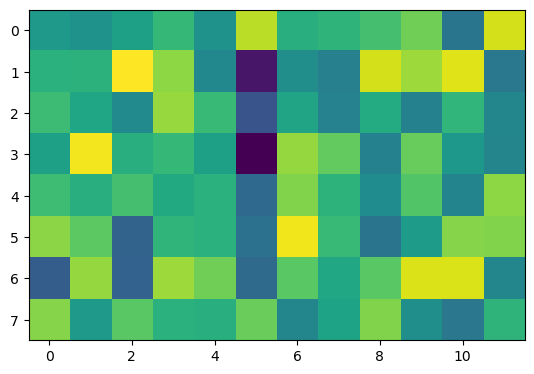

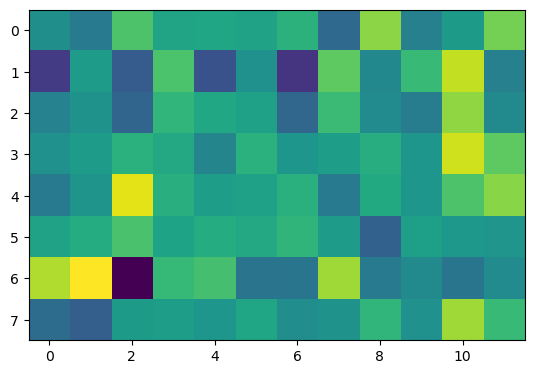

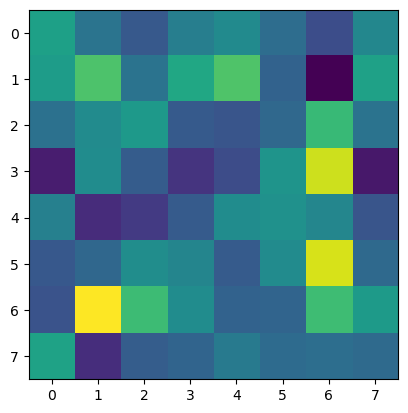

below after scaling and softmax


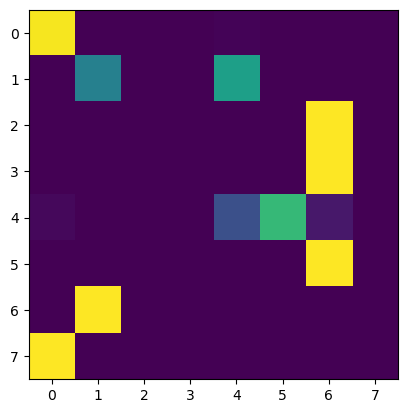

below without any scaling


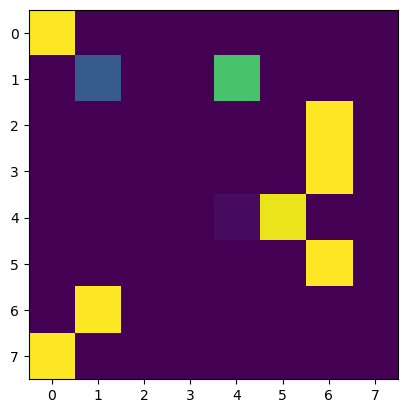

Final Output (with scaling)


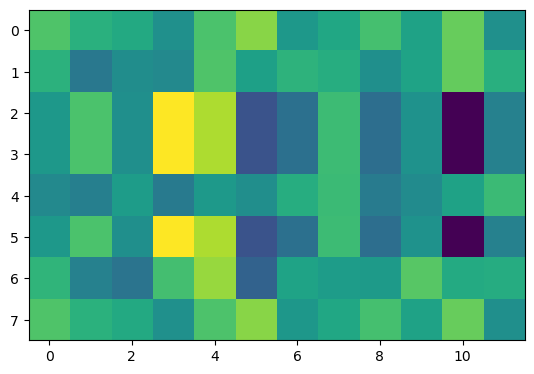

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# toy setup
seq_len = 8      # number of tokens
d_model = 12     # embedding dimension
d_head = d_model # since only 1 head, head dim = model dim

# random embeddings for 8 tokens
np.random.seed(42)
X = np.random.randn(seq_len, d_model)  # shape (8, 12)

# random query/key projection matrices
W_Q = np.random.randn(d_model, d_head)
W_K = np.random.randn(d_model, d_head)

# compute raw queries and keys
Q = X @ W_Q  # shape (8, 12)
K = X @ W_K  # shape (8, 12)

# compute attention scores
scores = Q @ K.T / np.sqrt(d_head)  # scaled dot-product, shape (8, 8) 
#- so that softmax doest produce only near the horizontal regions the scaling is applied

# apply softmax to get attention weights
attention_weights = np.exp(scores)
attention_weights /= attention_weights.sum(axis=1, keepdims=True)  # shape (8, 8)

# then multiply by v

# random value projection matrix
W_V = np.random.randn(d_model, d_head)

# compute values
V = X @ W_V  # shape (8, 12)

# compute attention output
Z = attention_weights @ V  # shape (8, 12)

# With multihead attention you have many of these Z (each made from it's own W_Q, W_K and W_V. 
# These are then concatenated against eachother

plt.imshow(Q)
plt.show()

plt.imshow(K)
plt.show()

plt.imshow(Q @ K.T)
plt.show()


print("below after scaling and softmax")

plt.imshow(attention_weights)
plt.show()

print("below without any scaling")
no_scale = np.exp(Q @ K.T)
no_scale/=no_scale.sum(axis=1, keepdims=True)  # shape (8, 8)

plt.imshow(no_scale)
plt.show()

print("Final Output (with scaling)")

plt.imshow(Z)
plt.show()


# S2 Aside - Rope - Rotary positional embeddings

In [17]:
# read through the below and look at the print statement outputs when called to understand
def apply_rope(x, position, d_model):
    """
    Apply RoPE to a single vector x at given position.
    x: shape (d_model,)
    position: integer position
    """

    print(f'x = {x}')
    print(f'position = {position}')
    print(f'd_model = {d_model}')


    half = d_model // 2
    print(f'half = {half}')
    freqs = np.exp(np.linspace(0., -1., half) * np.log(10000.))  # frequencies
    print(f'freqs = {freqs}')
    print(f'position = {position}')
    print(f'position * freqs = {position * freqs}')
    angles = position * freqs
    print(f'angles = {angles}')

    x_out = np.zeros_like(x)
    print(f'x_out = {x_out}')
    for i in range(half):
        cos, sin = np.cos(angles[i]), np.sin(angles[i])
        xi, xj = x[2*i], x[2*i+1]

        # 2D rotation
        x_out[2*i]   = xi * cos - xj * sin
        x_out[2*i+1] = xi * sin + xj * cos
    print(f'initial x = {x}')
    print(f'x_out final = {x_out}')
    return x_out

In [18]:
Q_rope = np.zeros_like(Q)
K_rope = np.zeros_like(K)

for pos in range(seq_len):
    Q_rope[pos] = apply_rope(Q[pos], pos, d_model)
    K_rope[pos] = apply_rope(K[pos], pos, d_model)

x = [-1.55586203 -2.00061881 -1.11869452  0.53628058 -2.11092356  4.39854111
 -0.11008244  0.28464758  1.15150177  2.50753788 -4.09651954  5.00397048]
position = 0
d_model = 12
half = 6
freqs = [1.00000000e+00 1.58489319e-01 2.51188643e-02 3.98107171e-03
 6.30957344e-04 1.00000000e-04]
position = 0
position * freqs = [0. 0. 0. 0. 0. 0.]
angles = [0. 0. 0. 0. 0. 0.]
x_out = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
initial x = [-1.55586203 -2.00061881 -1.11869452  0.53628058 -2.11092356  4.39854111
 -0.11008244  0.28464758  1.15150177  2.50753788 -4.09651954  5.00397048]
x_out final = [-1.55586203 -2.00061881 -1.11869452  0.53628058 -2.11092356  4.39854111
 -0.11008244  0.28464758  1.15150177  2.50753788 -4.09651954  5.00397048]
x = [-0.80649223 -2.41419155  3.47110607  0.83344127  0.94057406  0.69001062
  1.92252705 -3.77551795  5.43665565 -1.98965679  0.10453218  4.8056732 ]
position = 0
d_model = 12
half = 6
freqs = [1.00000000e+00 1.58489319e-01 2.51188643e-02 3.98107171e-03
 6.30957344

In [13]:
# attention scores with RoPE
scores_rope = Q_rope @ K_rope.T / np.sqrt(d_head)

# softmax along keys
attn_weights_rope = np.exp(scores_rope) / np.exp(scores_rope).sum(axis=-1, keepdims=True)

print("Raw query for token 0:", Q[0][:12])
print("RoPE query for token 0:", Q_rope[0][:12])
print("RoPE query for token 1:", Q_rope[1][:12])

correct / reword the below later

# In essence if you think of each embedding row as a vector in n dimensional space,
# rotary position embeddings rotate the vectors. 
# If they are near eachother they get rotated a similar amount, 
# if they are far apart, they get rotated different amounts widening the gap.
# When you do Q_rope @ K_rope.T / np.sqrt(d_head) you get pairwise weights. - similarity of tokens

Raw query for token 0: [-1.55586203 -2.00061881 -1.11869452  0.53628058]
RoPE query for token 0: [-1.55586203 -2.00061881 -1.11869452  0.53628058]
RoPE query for token 1: [-0.10045351  0.14268932  5.51780291  4.21316357]


# Convolution layers

https://www.youtube.com/watch?v=XBF9iqt0CnA

Convolutions help extract important features - write some more about here to summarise

https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html#torch.nn.functional.conv1d

https://www.youtube.com/shorts/s3kfsJ55BKQ

# Silu and Gelu - activation functions can also include relu sigmoid, softmax,  etc.

https://medium.com/@gauravnair/the-spark-your-neural-network-needs-understanding-the-significance-of-activation-functions-6b82d5f27fbf#c1ac

# Dustbin or consideration code

In [ ]:
#from utils - modelv2

class ConvMasked(nn.Module):
    """
    Applied modifications on Conv1d to make the masking work
    """
    def __init__(self, indim, outdim, kernel_size):
        super(ConvMasked, self).__init__()
        self.conv        = nn.Conv1d(indim, outdim, 
                                    kernel_size = kernel_size, padding = "valid")
        self.kernel_size = kernel_size
        self.indim       = indim

    def forward(self, x, mask = None):
        batch, _, _ = x.shape
        padding = torch.zeros(batch, self.indim, self.kernel_size - 1).to(x.device)
        x1      = torch.concat([x, padding], dim = 2)
        y       =  self.conv(x1)
        if mask is not None:
            y   = y * mask.unsqueeze(1) # unsqueeze the seequence part
        return y

class ConvBlock(nn.Module):
    def __init__(self, dim, convkernel):
        super(ConvBlock, self).__init__()
        self.c1 = ConvMasked(dim     , dim // 2, kernel_size=convkernel)
        self.s1 = nn.SiLU()
        self.c2 = ConvMasked(dim // 2, dim // 4, kernel_size=convkernel // 2)
        self.s2 = nn.SiLU()
        self.c3 = ConvMasked(dim // 4, dim // 2, kernel_size=convkernel)
        self.s3 = nn.SiLU()
        return
    
    def forward(self, x, mask = None): 
        x = rearrange(x, "b n c -> b c n")
        if mask is not None:
            x = x * mask.unsqueeze(1)
        x = self.s1(self.c1(x, mask))
        x = self.s2(self.c2(x, mask))
        x = self.s3(self.c3(x, mask))
        x = rearrange(x, "b c n -> b n c")
        return x

class Block(nn.Module):
    def __init__(self, dim = 2560, attnheads = 5, convkernel = 7):
        super(Block, self).__init__()
        self.encoder = TransformerLayer(embed_dim = dim, 
                                       ffn_embed_dim = 2 * dim,
                                       attention_heads = attnheads,
                                       use_rotary_embeddings = True)
        
        self.convblock = ConvBlock(dim, convkernel)
        self.final = nn.Linear(dim // 2, dim)
        
    def forward(self, x, mask = None):
        x    = rearrange(x, "b n c -> n b c")
        x, _ = self.encoder(x, self_attn_padding_mask = ~mask if mask is not None else mask) 
        x    = rearrange(x, "n b c -> b n c")

        x    = self.convblock(x, mask = mask)
        
        return self.final(x)
    
    
class BlockP(nn.Module):
    def __init__(self, dim = 2560, attnheads = 5, convkernel = 7):
        """
        Obsolete 
        """
        super(BlockP, self).__init__()
        self.encoder = TransformerLayer(embed_dim = dim, 
                                       ffn_embed_dim = 2 * dim,
                                       attention_heads = attnheads,
                                        use_rotary_embeddings = True
                                       )
        self.convblock = nn.Sequential(Rearrange("b n c -> b c n"),
                                       nn.Conv1d(dim, dim // 2, kernel_size = convkernel, padding = "same"),
                                       nn.SiLU(),
                                       nn.Conv1d(dim // 2, dim // 4, kernel_size = convkernel // 2, padding = "same"), 
                                       nn.SiLU(),
                                       nn.Conv1d(dim // 4, dim // 2, kernel_size = convkernel, padding = "same"),    
                                       Rearrange("b c n -> b n c"), 
                                       # nn.GELU(),
                                    )
        self.final = nn.Linear(dim // 2, dim)
        # self.norm1 = nn.LayerNorm(dim // 2)
        
    def forward(self, x, mask = None):
        """
        This is an older Block version which does not use mask. 
        """
        batch, seq, len = x.shape
        assert batch == 1, "Batch should be equal to one for this obsolete class"
        x = rearrange(x, "b n c -> n b c")
        x, _ = self.encoder(x)
        x = rearrange(x, "n b c -> b n c")
        x = self.convblock(x)
        # x = self.norm1(x)
        return self.final(x)

In [ ]:
#From raygun file (model vs2)
class RaygunEncoder(nn.Module):
    def __init__(self, dim = 1280, reduction = 50,
                 convkernel = 7,
                 nhead = 20, numencoders = 2, dropout = 0.2,
                 activation = "gelu"):
        super(RaygunEncoder, self).__init__()
        self.dropout = dropout

        self.encoders = nn.ModuleList()
        for i in range(numencoders):
            self.encoders.append(Block(dim = dim, 
                                       convkernel = convkernel, 
                                       attnheads = nhead))


        self.redlength = reduction
        self.reduction = Reduction(reduce_size = reduction)
        self.final     = nn.Sequential(
                            nn.Linear(dim * (numencoders+1), dim // (numencoders + 1) * 4),
                            nn.SiLU(),
                            nn.Linear(dim // (numencoders + 1) * 4, dim)
                         )

        nn.init.xavier_uniform_(self.final[0].weight, gain=1e-3)
        nn.init.xavier_uniform_(self.final[2].weight, gain=1e-3)
        nn.init.constant_(self.final[0].bias, 0)
        nn.init.constant_(self.final[2].bias, 0)

    def reduce(self, x, mask = None, noise = None):
        """
        Use the Reduction operation to compress the PLM representation to a fixed-dimension space.
        """
        batch, _, _ = x.shape
        if noise is not None:
            redmean, redstd = self.reduction(x, mask = mask, getstd = True)
            reduced = redmean + torch.randn_like(redstd, device = x.device) * redstd * noise
        else:
            reduced = self.reduction(x, mask = mask, getstd = False)
        return reduced

    def forward(self, x, mask = None, noise = None):
        """
        If error_c is provided, noise component is incorporated into the 
        fixed-dimensional representation. 
        """
        enc = self.reduce(x, mask = mask, noise = noise)
        residues = [enc]
        for mod in self.encoders:
            xresidue = mod(x, mask = mask)
            residue  = mod(self.reduce(xresidue, mask = mask, noise = noise)) # 
            x        = x + xresidue
            residues.append(residue)

        finalresidue = self.final(torch.concat(residues, dim = -1)) 
        return enc + finalresidue      


class RaygunDecoder(nn.Module):
    def __init__(self, dim = 1280, numdecoders = 5, convkernel = 7,
                 nhead = 20, dropout = 0.1, activation = "gelu"):
        super(RaygunDecoder, self).__init__()
        self.dbefore = nn.ModuleList()
         
        for i in range(numdecoders):
            self.dbefore.append(Block(dim = dim,
                                      convkernel = convkernel,
                                      attnheads = nhead,
                                      ))

        self.repetition = Repetition()

        self.dafter = nn.ModuleList()
        for i in range(numdecoders+1):
            self.dafter.append(Block(dim = dim,
                                      convkernel = convkernel, 
                                      attnheads = nhead, 
                                      ))
        self.final = nn.Sequential(
                            nn.Linear(dim * (numdecoders+2), dim // (numdecoders+2) * 4),
                            nn.SiLU(),
                            nn.Linear(dim // (numdecoders+2) * 4, dim)
                        )

    def forward(self, encoding, finallengths, mask = None):
        """
        Decoder is entirely deterministic. No noise added here.
        """
        out = self.repetition(encoding, finallengths)
        # construct different encoding replicates
        ereplicates = []
        ereplicates.append(encoding)
        for mod in self.dbefore:
            encoding = encoding + mod(encoding, mask = mask)
            ereplicates.append(encoding)
        ## for each replicates, expand and apply model
        outreplicates = [out]
        for ereplicate, mod in zip(ereplicates, self.dafter):
            outreplicates.append(mod(self.repetition(ereplicate, finallengths),
                                    mask = mask))
        return out + self.final(torch.concat(outreplicates, dim = -1))

class Raygun(nn.Module):
    def __init__(self, dim = 1280, nhead = 20, convkernel = 7, 
                 numencoders = 10, numdecoders = 10,
                 dropout = 0.1,
                 reduction = 50, activation = "gelu",
                 esmdecodertotokenfile = None, 
                 fixed_esm_batching=False):
        super(Raygun, self).__init__()
        self.encoder = RaygunEncoder(dim     = dim, 
                                reduction    = reduction, 
                                convkernel   = convkernel,
                                numencoders  = numencoders, 
                                dropout      = dropout, 
                                activation   = activation,
                                nhead        = nhead)
        self.decoder = RaygunDecoder(dim     = dim, 
                                 nhead       = nhead, 
                                 convkernel  = convkernel,
                                 numdecoders = numdecoders,
                                 dropout     = dropout, 
                                 activation  = activation)

        self.esmdecoder = DecoderBlock(dim = dim, 
                                      nhead = 20, 
                                      fixed_batching=fixed_esm_batching)
        if esmdecodertotokenfile is not None:
            checkpoint = torch.load(esmdecodertotokenfile)
            self.esmdecoder.load_state_dict(checkpoint["model_state"])
            del checkpoint
        self.alphtotoks  = {'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}
        self.esmalphdict = {i:k for k, i in self.alphtotoks.items()}

    def get_sequence_from_logits(self, logits, lengths):
        batch, seq, _ = logits.shape
        if batch == 1:
            assert isinstance(lengths, int) or lengths.shape[0] == 1, "batch=1 but multiple lengths provided"
            if isinstance(lengths, int):
                lengths = [lengths]
        else:
            assert len(lengths.shape) == 1 and lengths.shape[0] == batch, "batch size and `lengths` dimension should be the same"
        output_seqs   = []
        with torch.no_grad():
            for idx, length in enumerate(lengths):
                logit   = logits[idx, :length, :]
                ptokens = torch.argmax(logit, dim = -1).cpu().numpy().tolist()
                pseqs   = "".join([self.esmalphdict[t] if t in set(range(4, 29)) else "X" 
                                  for t in ptokens])
                output_seqs.append(pseqs)
        return output_seqs

    def get_sequences_from_fixed(self, fixedembs, lengths):
        with torch.no_grad():
            out    = self.decoder(fixedembs, lengths)
            logits = self.esmdecoder(out)
        return self.get_sequence_from_logits(logits, lengths)
    
    def forward(self, x, mask = None, 
                target_lengths = None, 
                noise = None, 
                token = None, 
                return_logits_and_seqs = False):
        """
        Arguments:
        x    -> [batch, seq, dim]: ESM-2 650M embedding
        mask -> [batch, seq]: Binary matrix. Suppose the sequence length of a  `batch_id` is `n`. Then mask[batch_id] should be such that mask[batch_id, :n] = 1 and mask[batch_id, n:] = 0  
        output_lengths -> [batch]: target length
        """
        batch, length_, dim = x.shape
        if target_lengths is not None:
            assert target_lengths.shape[0] == batch, "`output_lengths` should be a 1d tensor, its dimension should match the batch size"
            lengths = target_lengths
        elif batch == 1:
            lengths = length_  
        else:
            assert mask is not None, "batch larger than 1 but mask is Null"
            lengths = mask.sum(dim = -1)
        mem = self.encoder(x, mask = mask, noise = noise)
        out = self.decoder(mem, lengths)
        
        result = {"fixed_length_embedding": mem, 
                 "reconstructed_embedding": out}
        
        if token is not None or return_logits_and_seqs:
            logits          = self.esmdecoder(out) #batch, seq, token
            result["logits"] = logits
            
        if token is not None:
            if len(token.shape) == 3:
                tok   = rearrange(token, "b h k -> (b h k)")
            else:
                tok   = rearrange(token, "b k -> (b k)")
            loss      = F.cross_entropy(rearrange(logits, "b h k -> (b h) k"), 
                                        tok, ignore_index = 1)
            result["ce_loss"] = loss
        if return_logits_and_seqs:
            result["generated-sequences"] = self.get_sequence_from_logits(logits, lengths)
        return result

In [ ]:
## Dustbin or consideration code: 

import torch
import torch.nn.functional as F

def custom_anti_pool1d(x_mean, desired_output_size):
    # x_mean shape: (B, C, L_in)
    B, C, L_in = x_mean.shape
    L_out = desired_output_size

    ratio = L_out / L_in
    N_rep = int(torch.floor(torch.tensor(ratio)))  # Integer replication factor (e.g., 4)
    F_blend = ratio - N_rep                       # Fractional blend factor (e.g., 0.5)

    if N_rep == 0:
        # Fallback if the ratio is < 1 (e.g., use linear interpolation for reduction)
        return F.interpolate(x_mean, size=L_out, mode='linear')
    
    # --- Step 1: Nearest-Neighbor-like Replication (L_in * N_rep) ---
    # F.interpolate with mode='nearest' and a scale_factor is efficient for replication
    x_replicate = F.interpolate(
        input=x_mean,
        scale_factor=N_rep,
        mode='nearest'
    )
    
    # Target length after replication: L_rep = L_in * N_rep

    # --- Step 2: Calculate Boundary Values ---
    # Boundary values are calculated between consecutive elements: (x_{i} * F_blend) + (x_{i+1} * (1 - F_blend))
    # Note: Since your example used (1/2x + 1/2y), F_blend should be interpreted as the weight of the *next* element.
    # We will use F_blend as the weight of the *current* element for consistency with standard weighted average for a boundary:
    # Blend = (x_i * (1 - F_blend)) + (x_{i+1} * F_blend)
    # If F_blend = 0.5, this is simply (x_i + x_{i+1}) / 2

    # Shift tensor to get x_{i+1}
    x_shifted = torch.roll(x_mean, shifts=-1, dims=-1)
    
    # Boundary values (for all L_in - 1 boundaries)
    # e.g., for i=0: (x_0 * (1 - F_blend)) + (x_1 * F_blend)
    boundary_values = (x_mean * (1 - F_blend)) + (x_shifted * F_blend)
    
    # We only need L_in - 1 boundary values (last one is irrelevant as it's the boundary after the last element)
    boundary_values = boundary_values[..., :-1] 
    
    # --- Step 3: Interleave Replication and Boundary Values ---
    
    # Pre-allocate the final tensor of size (B, C, L_out)
    x_upscale = torch.zeros(B, C, L_out, device=x_mean.device, dtype=x_mean.dtype)
    
    # Indices for the start of each block: 0, N_rep, 2*N_rep, ...
    # Indices for the boundary values: N_rep, 2*N_rep, 3*N_rep, ...
    
    for i in range(L_in - 1):
        # Place the replicated block (x_i, x_i, ..., x_i)
        start_idx = i * (N_rep + 1)
        x_upscale[..., start_idx : start_idx + N_rep] = x_replicate[..., i * N_rep : (i + 1) * N_rep]
        
        # Place the boundary value
        boundary_idx = start_idx + N_rep
        x_upscale[..., boundary_idx] = boundary_values[..., i]

    # --- Step 4: Handle the Final Block ---
    # The last block has no boundary value after it, only the replicated values.
    # The last block starts at (L_in - 1) * (N_rep + 1)
    last_block_start = (L_in - 1) * (N_rep + 1)
    # The replicated part of the last element starts at (L_in - 1) * N_rep in x_replicate
    last_rep_start = (L_in - 1) * N_rep
    
    x_upscale[..., last_block_start : L_out] = x_replicate[..., last_rep_start : last_rep_start + (L_out - last_block_start)]

    return x_upscale

# Example Usage:
x_mean = torch.tensor([[[10.0, 20.0]]]) # L_in = 2, x=10.0, y=20.0
desired_output_size = 9 # L_out = 9, Ratio = 4.5

x_upscale_custom = custom_anti_pool1d(x_mean, desired_output_size)
print(x_upscale_custom)

# Desired output: [10.0, 10.0, 10.0, 10.0, 15.0, 20.0, 20.0, 20.0, 20.0]
# Where 15.0 is (10.0 + 20.0)/2
        




